In [314]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from datetime import datetime
import matplotlib.animation as animation
from copy import deepcopy as copy
from src import convert
from IPython.display import display as disp, Math, Latex
import scipy.signal
def print_latex(code):
  """Print a LaTeX string."""
  disp(Math(code))

---

# 1. Introduction

### Initialization

In [315]:
start_time = datetime.now()

# Data extracted from the horizon results
DT = 600 # in seconds
T = 2500

### Body class

In [316]:
class Body():

    all = []

    def __init__(self, name, pos, vel, acc, gm):
        self.name = name
        self.pos = pos
        self.initial_pos = pos
        self.vel = vel
        self.initial_vel = vel
        self.acc = acc
        self.initial_acc = acc
        self.gm = gm
        self.pos_evol = np.zeros((T,3))
        self.pos_evol[0] = self.pos
        self.vel_evol = np.zeros((T,3))
        self.vel_evol[0] = self.vel
        self.acc_evol = np.zeros((T,3))
        self.acc_evol[0] = self.acc
        Body.all.append(self)

### Body definition

In [317]:
mimas = Body(
    name = 'Mimas',
    pos  = np.array([-1.813557294137345E+05, 3.492995866271013E+04, 5.054192147215439E+03]),
    vel  = np.array([-2.445920348718876E+00, 1.416736794928916E+01, 1.873213454946043E-02]),
    acc  = np.array([0,0,0]),
    gm   = 2.503489)

thetys = Body(
    name = 'Thetys',
    pos  = np.array([-1.889929479196472E+05, -2.260662471700913E+05, -7.020174976279632E+02]),
    vel  = np.array([8.706811449016753E+00, -7.280896606319645E+00, -2.143307520131600E-01]),
    acc  = np.array([0,0,0]),
    gm   = 41.21)

titan = Body(
    name = 'Titan',
    pos  = np.array([2.956179324256932E+05, 1.212611254175863E+06, -6.683800852915738E+02]),
    vel  = np.array([-5.322398770209340E+00, 1.190373084298060E+00, -3.847254100240810E-02]),
    acc  = np.array([0,0,0]),
    gm   = 8978.14)

saturn = Body(
    name = 'Saturn',
    pos  = np.array([0,0,0]),
    vel  = np.array([0,0,0]),
    acc  = np.array([0,0,0]),
    gm   = 37931206.2)

saturn.R = 58232 # km
saturn.J2 = 1.629e-2

# Initial acceleration
# for body in [mimas, thetys, titan]:
#     body.acc = body.compute_acceleration(saturn)

---

# 2. Integration

### Runge-Kutta integrator

In [318]:
# Acceleration function : f(t,y) -> (v,a)     with y = (p,v)
def acceleration_rk(t, y, body = None, perturbated=False, saturn_flattened=False) -> np.array:
    pos = y[:3]
    vel = y[3:]

    gm = body.gm if body is not None else 0

    r = pos
    d = np.sqrt(np.sum(r**2))

    if not saturn_flattened:
        acc = - r * (saturn.gm + gm) / (d**3)
    else:
        acc = np.zeros(3) - 3/2 * (saturn.gm + gm) * saturn.J2 * saturn.R**2 / d**7
        acc[0] *= r[0] * (  r[0]**2 +   r[1]**2 - 4*r[2]**2)
        acc[1] *= r[1] * (  r[0]**2 +   r[1]**2 - 4*r[2]**2)
        acc[2] *= r[2] * (3*r[0]**2 + 3*r[1]**2 - 2*r[2]**2)

    if perturbated:
        for other_body in [mimas, thetys, titan]:
            if (other_body is body):
                continue
            r = other_body.pos - pos
            d = np.sqrt(np.sum(r**2))
            acc = acc - r * body.gm / (d**3)

    return np.concatenate((vel, acc))

# Runge kutta 4th order : rk4(t,dt,y,evaluate) -> y     with y = (p,v)
def rk4(t,dt,y,evaluate, body = None, perturbated=False, saturn_flattened=False) -> np.array:

    k1 = evaluate(t, y,                      body=body, perturbated=perturbated, saturn_flattened=saturn_flattened)
    k2 = evaluate(t + 0.5*dt, y + 0.5*k1*dt, body=body, perturbated=perturbated, saturn_flattened=saturn_flattened)
    k3 = evaluate(t + 0.5*dt, y + 0.5*k2*dt, body=body, perturbated=perturbated, saturn_flattened=saturn_flattened)
    k4 = evaluate(t + dt, y + dt*k3,         body=body, perturbated=perturbated, saturn_flattened=saturn_flattened)
    
    y_new = y + (1./6.)*(k1+ 2.*k2 + 2.*k3 + k4) * dt

    return y_new

In [319]:
def acceleration_lf(body, perturbated=False, saturn_flattened=False):
    
    r = body.pos
    d = np.sqrt(np.sum(r**2))

    if not saturn_flattened:
        acc = - r * (saturn.gm + body.gm) / (d**3)
    else:
        acc = np.zeros(3) - 3/2 * (saturn.gm + body.gm) * saturn.J2 * saturn.R**2 / d**7
        acc[0] *= r[0] * (  r[0]**2 +   r[1]**2 - 4*r[2]**2)
        acc[1] *= r[1] * (  r[0]**2 +   r[1]**2 - 4*r[2]**2)
        acc[2] *= r[2] * (3*r[0]**2 + 3*r[1]**2 - 2*r[2]**2)

    if perturbated:
        for other_body in [mimas, thetys, titan]:
            if (other_body is body):
                continue
            r = body.pos - other_body.pos
            d = np.sqrt(np.sum(r**2))
            acc = acc - r * other_body.gm / (d**3)

    return acc

### Time evolution

In [320]:

# Evolve using Runge Kutta method
def evolve_rk(T=T, perturbated=False, saturn_flattened=False):

    for body in Body.all:
        body.pos = body.initial_pos
        body.vel = body.initial_vel
        body.acc = body.initial_acc

    for t in range(1,T):    
        for body in [mimas, thetys, titan]:

            y = np.concatenate((body.pos, body.vel))
            y = rk4(t*DT, DT, y, acceleration_rk, body=body, perturbated=perturbated, saturn_flattened=saturn_flattened)

            body.pos = y[:3]
            body.vel = y[3:]

            body.pos_evol[t] = body.pos
            body.vel_evol[t] = body.vel

In [321]:
# Evolve using Leap Frog method
def evolve_lf(T=T, perturbated=False, saturn_flattened=False):

    for body in Body.all:
        body.pos = body.initial_pos
        body.vel = body.initial_vel
        body.acc = body.initial_acc

    for t in range(1,T):
        for body in [mimas, thetys, titan]:

            body.pos = body.pos + body.vel * DT + body.acc/2 * DT**2
            body.vel =            body.vel      + body.acc/2 * DT
            body.acc = acceleration_lf(body, perturbated=perturbated, saturn_flattened=saturn_flattened)
            body.vel =            body.vel      + body.acc/2 * DT

            body.pos_evol[t] = body.pos
            body.vel_evol[t] = body.vel

In [322]:
# Compute evolution
evolve_rk()

### Plot position evolution

In [323]:
def plot_pos_evol(bodies=Body.all):
    fig = plt.figure(figsize=(15,5))

    # Evolution of the x coordinate
    plt.subplot(131)
    plt.title('Evolution of the x coordinate')
    for body in bodies:
        plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,0], label=body.name)
    plt.xlabel('Time [days]')
    plt.ylabel('x [km]')
    plt.legend()

    # Evolution of the y coordinate
    plt.subplot(132)
    plt.title('Evolution of the y coordinate')
    for body in bodies:
        plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,1], label=body.name)
    plt.xlabel('Time [days]')
    plt.ylabel('y [km]')
    plt.legend()

    # Evolution of the z coordinate
    plt.subplot(133)
    plt.title('Evolution of the z coordinate')
    for body in bodies:
        plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,2], label=body.name)
    plt.xlabel('Time [days]')
    plt.ylabel('z [km]')
    plt.legend()
    plt.show()

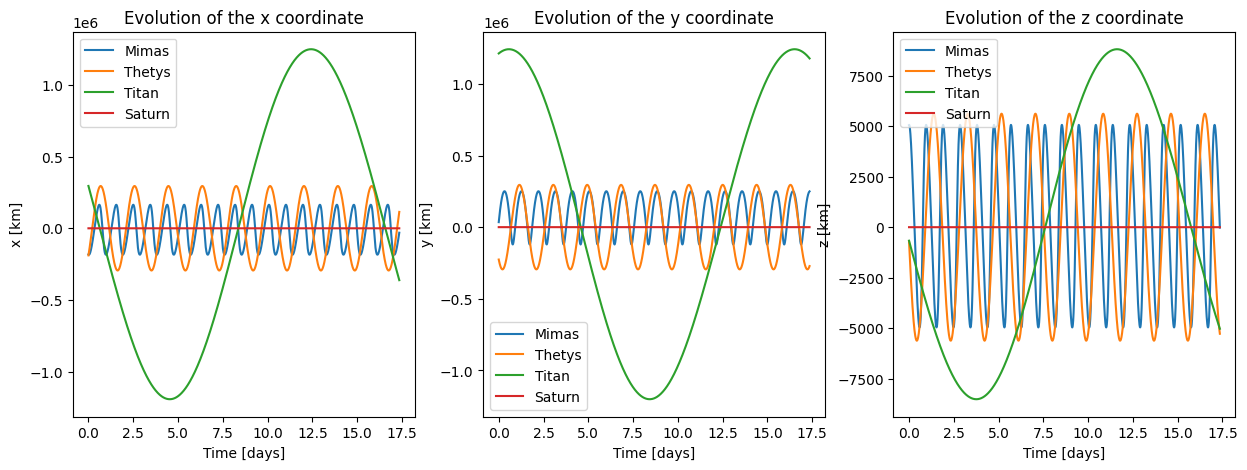

In [324]:
plot_pos_evol(Body.all)

### 3D representation of orbits

In [325]:
def plot_orbits_3D(bodies=Body.all):
    fig = plt.figure(figsize=(5,5))

    ax = plt.subplot(111, projection='3d')
    ax.set_title('Orbits of the bodies')
    for body in bodies:
        ax.plot(body.pos_evol[:,0], body.pos_evol[:,1], body.pos_evol[:,2], marker='o', label=body.name)
    
    plt.show()

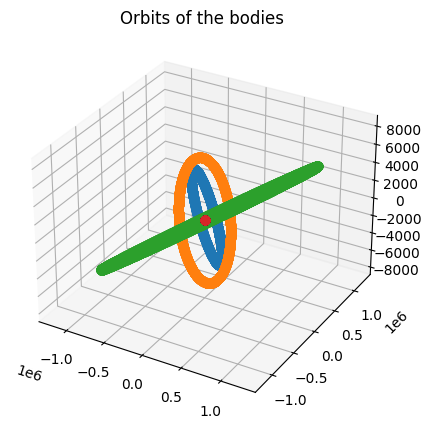

In [326]:
plot_orbits_3D(Body.all)

### Plot velocity evolution

In [327]:
def plot_vel_evol(bodies=Body.all):
    fig = plt.figure(figsize=(15,5))

    # Evolution of the x velocity
    plt.subplot(131)
    plt.title('Evolution of the x velocity')
    for body in bodies:
        plt.plot(np.arange(T)*DT/86400.0, body.vel_evol[:,0], label=body.name)
    plt.xlabel('Time [days]')
    plt.ylabel('Vx [km/s]')
    plt.legend()

    # Evolution of the y velocity
    plt.subplot(132)
    plt.title('Evolution of the y velocity')
    for body in bodies:
        plt.plot(np.arange(T)*DT/86400.0, body.vel_evol[:,1], label=body.name)
    plt.xlabel('Time [days]')
    plt.ylabel('Vy [km/s]')
    plt.legend()

    # Evolution of the z velocity
    plt.subplot(133)
    plt.title('Evolution of the z velocity')
    for body in bodies:
        plt.plot(np.arange(T)*DT/86400.0, body.vel_evol[:,2], label=body.name)
    plt.xlabel('Time [days]')
    plt.ylabel('Vz [km/s]')
    plt.legend()
    plt.show()

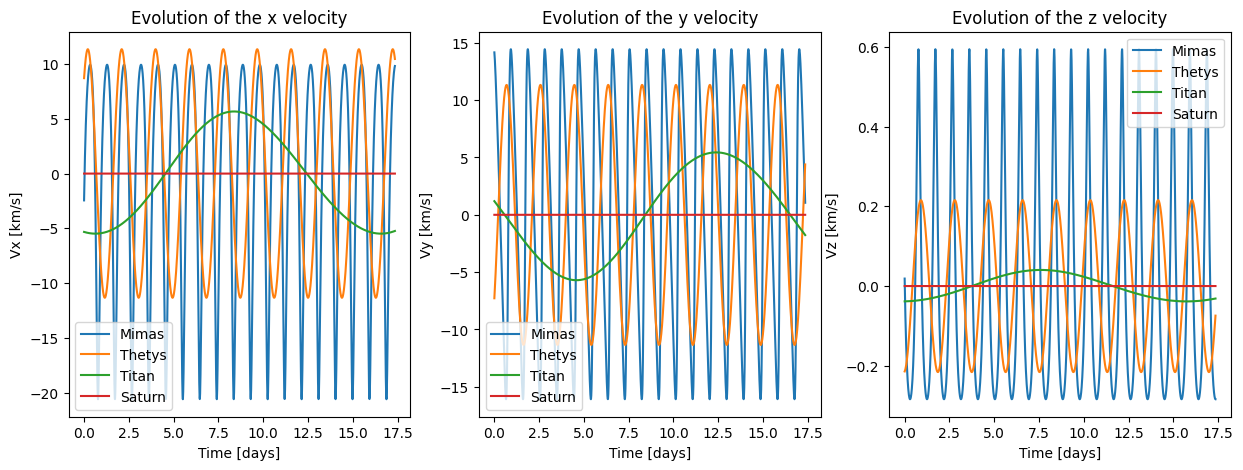

In [328]:
plot_vel_evol(Body.all)

---

# 3. Switching from cartesian to keplerian elements, and conversely

### Convert to orbital elements

In [329]:
def compute_orbital_evol(bodies=Body.all):
    for body in bodies:
        body.orb_evol = np.zeros((T,6))
        for t in range(0,T):
            body.orb_evol[t] = convert.cartesian_to_orbital(body.pos_evol[t], body.vel_evol[t], saturn.gm + body.gm)

In [330]:
def orbital_element_to_string(ell):
    ell = [round(i,3) for i in ell]
    return r"a="+str(ell[0])+r"\quad e="+str(ell[1])+r"\quad i="+str(ell[2])+r"\quad \Omega="+str(ell[3])+r"\quad \varpi="+str(ell[4])+r"\quad \lambda="+str(ell[5])

In [331]:
def print_orbital_elements(bodies=[mimas, thetys, titan]):
    for body in bodies:
        for t in range(0,T):
            if t == 0:
                ell = orbital_element_to_string(body.orb_evol[t])
                string = r"\text{" + body.name + r"'s initial keplerian elements:\quad}"+ell
            if t == T-1:
                ell = orbital_element_to_string(body.orb_evol[t])
                print_latex(string + r"\\ \text{" + body.name + r"'s final keplerian elements:\quad}"+ell)

In [332]:
compute_orbital_evol(Body.all)
print_orbital_elements([mimas, thetys, titan])

c:\Users\vince\Documents\Dev\CompuPhys\M2-Saturn-moons\src\convert.py:81: RuntimeWarning: invalid value encountered in double_scalars
  cis2 = np.sqrt(0.5 * (1 + gz / gg))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

When the system is not perturbated, we see that the orbital elements are conserved.

---

# 4. Including the mutual perturbations

### Adding perturbations

In [333]:
evolve_rk(perturbated=True)

### Plot position evolution

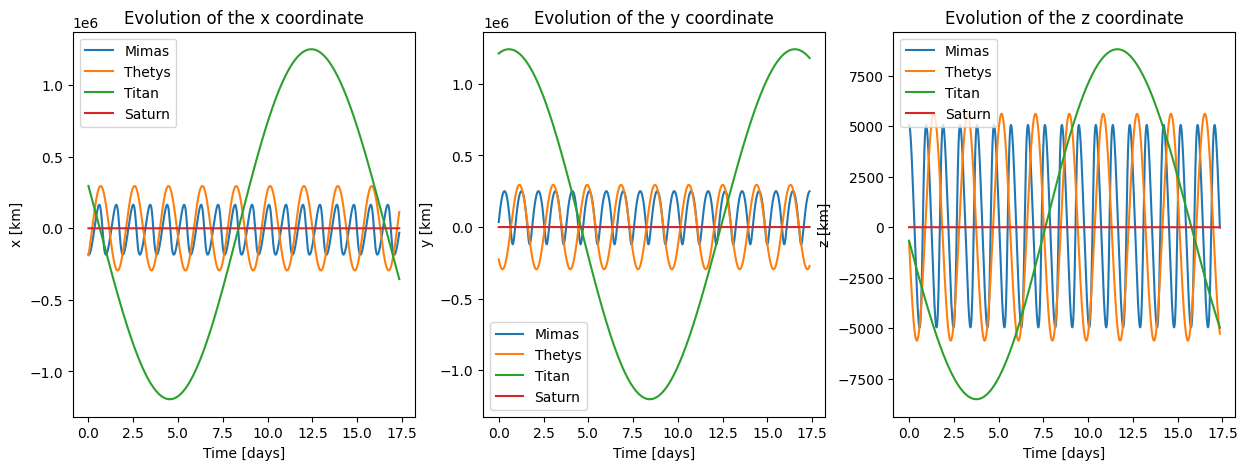

In [334]:
plot_pos_evol(Body.all)

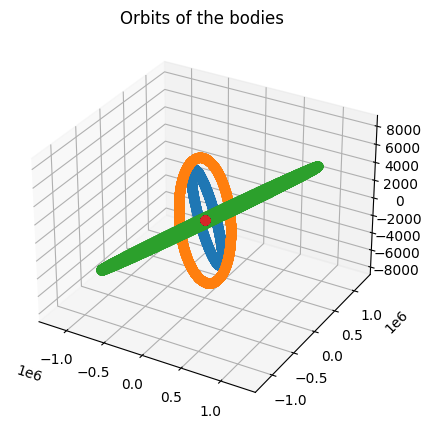

In [335]:
plot_orbits_3D(Body.all)

### Orbital elements

In [336]:
print_orbital_elements([mimas, thetys, titan])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

---

# 5. The flattening of Saturn

In [337]:
evolve_lf(perturbated=True, saturn_flattened=True)

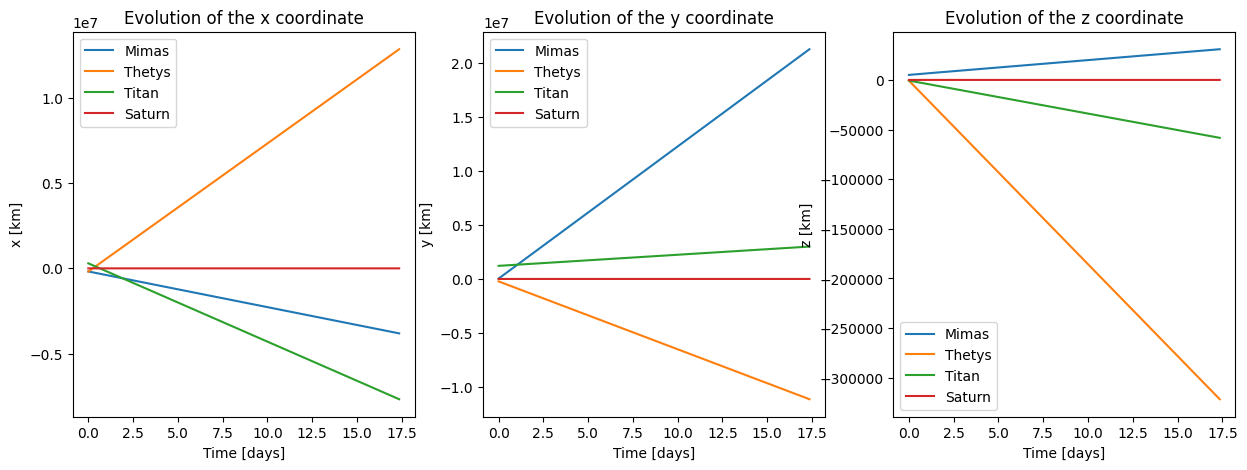

In [338]:
plot_pos_evol(Body.all)

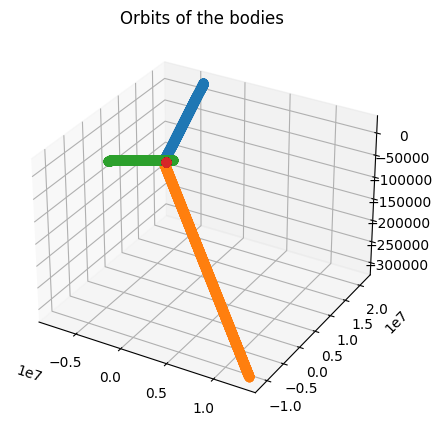

In [339]:
plot_orbits_3D(Body.all)

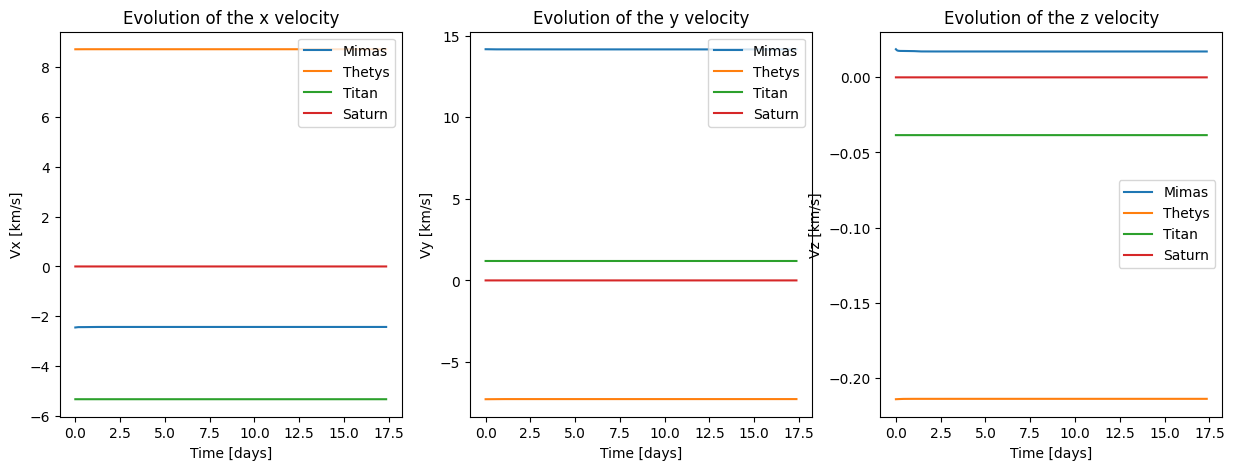

In [340]:
plot_vel_evol(Body.all)

In [341]:
compute_orbital_evol(Body.all)
print_orbital_elements([mimas, thetys, titan])

c:\Users\vince\Documents\Dev\CompuPhys\M2-Saturn-moons\src\convert.py:104: RuntimeWarning: invalid value encountered in sqrt
  psi = 1/(1+np.sqrt(1-k*k-h*h))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

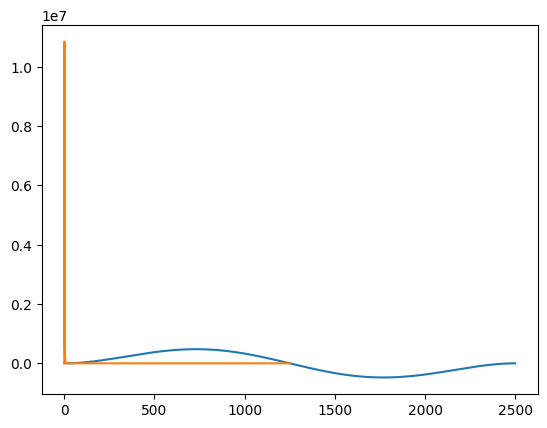

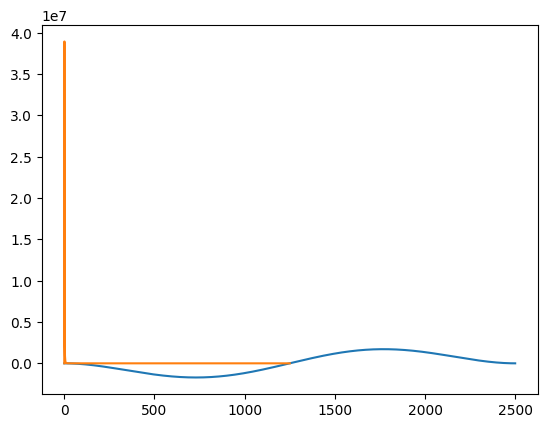

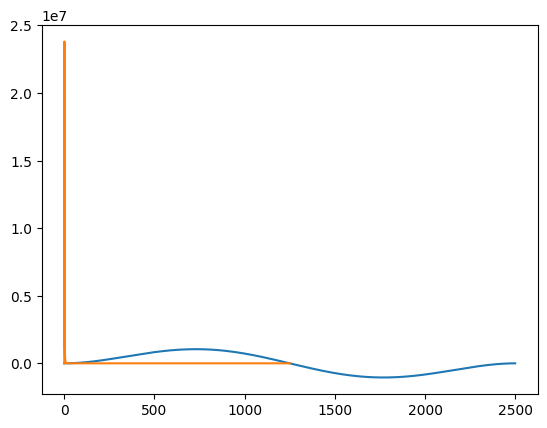

In [343]:
for body in [mimas, thetys, titan]:
    arg_maximums = []
    for i in range(T):
        

    body.T = np.fft.fft(body.pos_evol[:,0])

    # n = 2*np.pi / body.T
    # print(3/2 * saturn.J2 * n * (saturn.R * a)**2)